In [3]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [4]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Define model

In [5]:
class Simple3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            # 13x16x16
            
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool3d(2),
            # 6x8x8
            
            nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool3d(2),
            # 3x4x4
        )
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        
        self.fc = nn.Linear(256, 1)
        
#         self.fc = nn.Linear(256*3*4*4, 1)
        
        

    def forward(self, x):  
        x = self.backbone(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
N, C, D, H, W = 5, 1, 26, 32, 32
X = torch.randn(N, C, D, H, W)

model = Simple3DNet()
output = model(X)
output.shape

torch.Size([5, 1])

In [7]:
output

tensor([[-0.2033],
        [-0.2078],
        [-0.2022],
        [-0.2064],
        [-0.2061]], grad_fn=<AddmmBackward>)

# Setup dataset

In [8]:
IMG_SIZE = 256
PATH_TO_DATA = './data/'
IMG_PATH_TRAIN = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'train')
IMG_PATH_TEST = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'test')

In [9]:
train_labels_df = pd.read_csv(PATH_TO_DATA + 'train_labels.csv')
train_labels_df.shape

(585, 2)

In [10]:
class Image3DDataset(Dataset):
    def __init__(self, df, path, transform=None):

        self.df = df
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        label = train_labels_df['MGMT_value'][index]
        case_id = train_labels_df['BraTS21ID'][index]
        case_id = f'{case_id:0>5d}'

        # - FLAIR
        # - T1w
        # - T1wCE
        # - T2w
        MRI_TYPE = 'FLAIR'
        
        images_path = os.path.join(IMG_PATH_TRAIN, case_id, MRI_TYPE)

        # name = 'Image-100.png'
        image_names = sorted(os.listdir(images_path), key=lambda name: int(name[6:][:-4]))
        images = []
        
        for image_name in image_names:
            image_path = os.path.join(images_path, image_name)
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
            
            # H x W 
            image = np.array(image).astype(np.float32)
            
            # image -= 128?
            image /= 255
            
            
            # C x H x W
            image = np.expand_dims(image, axis=0)
                    
            images.append(image)
            
        # C x D x H x W
        image_3d = np.stack(images, axis=1)
               
        return image_3d, label

In [11]:
from torchvision import transforms as T

def get_train_transform(img_size):
    transform = T.Compose([
        T.Resize((img_size, img_size)),
#         T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406],
        #             std=[0.229, 0.224, 0.225])
    ])
    return transform

In [12]:
train_dataset = Image3DDataset(train_labels_df, IMG_PATH_TRAIN, get_train_transform(IMG_SIZE))
len(train_dataset)

585

In [13]:
image, label = train_dataset[1]
type(image), image.shape, label

(numpy.ndarray, (1, 67, 256, 256), 1)

In [14]:
image[0, 40].reshape(-1).shape

(65536,)

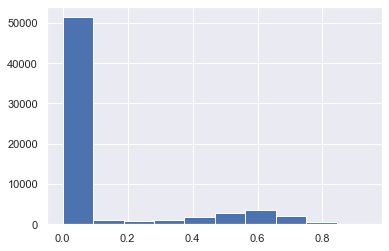

In [15]:
plt.hist(image[0, 40].reshape(-1))
plt.show()

In [22]:
# do we need to have equal D for all cases in batch?
# looks like yes
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
len(train_loader)

585

In [23]:
train_loader_iter = iter(train_loader)

In [24]:
x_batch, y_batch = next(train_loader_iter)
x_batch.shape, y_batch.shape

(torch.Size([1, 1, 143, 256, 256]), torch.Size([1]))

In [25]:
x_batch.max()

tensor(0.9961)

In [26]:
# y_batch = y_batch.long()
# y_batch = y_batch.type(torch.LongTensor)

In [27]:
y_batch, y_batch.dtype

(tensor([1]), torch.int64)

# Single model path

In [28]:
model = Simple3DNet()

In [29]:
%%time
output = model(x_batch)
output.shape

CPU times: user 28.6 s, sys: 5.67 s, total: 34.3 s
Wall time: 34.7 s


torch.Size([1, 1])

In [30]:
criterion = nn.BCEWithLogitsLoss()

In [31]:
# output.dtype, y_batch.dtype

In [33]:
y_batch = y_batch.type_as(output)
loss = criterion(output.squeeze(1), y_batch)

In [34]:
loss

tensor(0.6997, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [36]:
output, y_batch

(tensor([[-0.0130]], grad_fn=<AddmmBackward>), tensor([1.]))

In [37]:
output.shape, y_batch.shape

(torch.Size([1, 1]), torch.Size([1]))

In [39]:
indices = torch.argmax(output, 1)
indices

tensor([0])

In [58]:
y_pred = (output > 0)
# y_pred = torch.sigmoid(output)
# y_pred = y_pred > 0.5
y_pred.shape

torch.Size([1, 1])

In [57]:
correct_samples = torch.sum(y_pred == y_batch)
correct_samples

tensor(0)

In [59]:
y_batch.shape[0]

1

# Overfit small dataset

In [29]:
train_number = 10
train_df = train_labels_df.sample(frac=1).reset_index(drop=True).head(train_number)
train_df

,BraTS21ID,MGMT_value
0,9,0
1,1009,0
2,432,0
3,366,1
4,731,1
5,532,1
6,488,1
7,309,0
8,270,1
9,588,0


In [30]:
train_dataset = Image3DDataset(train_df, IMG_PATH_TRAIN, get_train_transform(IMG_SIZE))
len(train_dataset)

10

In [31]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
len(train_loader)

10

In [32]:
from train import train_num_iter
from utils import get_device

In [33]:
device = get_device()

No GPU available, using the CPU instead.


In [34]:
model = model.to(device)

In [35]:
learning_rate = 0.001
weight_decay = 0

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay,
    nesterov=True
)

In [ ]:
max_iter = 10
print_every = 1

train_num_iter(model, device, train_loader, criterion, optimizer, max_iter, print_every=print_every)

[train] iter:    0, loss = 0.69925, score = 0.00000, time: 0:00:45
[train] iter:    1, loss = 0.69894, score = 0.00000, time: 0:01:32
[train] iter:    2, loss = 0.69546, score = 0.33333, time: 0:00:43
[train] iter:    3, loss = 0.69609, score = 0.25000, time: 0:00:41
